## **1. Risk-Free Interest Rates**

无风险利率的实践定位
美国国债收益率作为市场公认的无风险利率基准
✔️ 理论争议：存在主权违约可能性（如2011年债务上限危机）
✔️ 市场惯例：金融定价（债券/衍生品/资本成本）仍以美债为锚
公司债收益率 = 国债收益率（无风险利率） + 信用利差

2. 信用利差(Credit Spread)本质
信用利差——风险“保护费”
场景：
借给美国政府：年息3% → 几乎零风险
借给某房企：年息9% → 多收6%是怕它倒闭跑路
这6%就是信用利差！
规律：
经济好时：保护费低（利差3-4%）
经济差时：保护费暴涨（利差飙到10%+）

2022年美联储加息：3. 国债波动三规律——债券的“脾气”
1年期国债利息：1天跳涨0.5% → 暴脾气发作
30年期国债：1个月慢涨1% → 闷火酝酿
5年期国债：纹丝不动 → 老好人淡定


曲线拟合——找“债券价格漏洞”
核心玩法：
第1步：用数学模型画条“完美曲线”（理论价格）
第2步：对比真实市场价格
第3步：发现异常点 → 捡钱机会！
举个栗子🌰：
模型算出3年期债该卖102元
市场恐慌抛售→只卖98元
→ 立刻买入！等价格回归净赚4元





In [8]:
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [9]:
from config_constant import FRED_API_KEY

# Initialize the FRED API with your key
fred = Fred(api_key=FRED_API_KEY)

# List of Treasury yield series IDs
series_ids = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', \
              'DGS7', 'DGS10', 'DGS20', 'DGS30']

# Function to get data for a single series
def get_yield_data(series_id):
    data = fred.get_series(series_id, observation_start="1975-01-01", observation_end="2024-05-03")
    return data

# Get data for all series
yields_dict = {series_id: get_yield_data(series_id) for series_id in series_ids}

# Combine into a single DataFrame
yields = pd.DataFrame(yields_dict)

# Rename columns for clarity
yields.columns = ['1 Month', '3 Month', '6 Month', '1 Year', '2 Year', '3 Year', '5 Year', \
                  '7 Year', '10 Year', '20 Year', '30 Year']

In [10]:
yields.index = pd.to_datetime(yields.index)

# 2. 计算波动率（标准差）


In [11]:
yields = yields.dropna()
y_std = yields.std()
y_std

1 Month    1.705851
3 Month    1.733347
6 Month    1.746829
1 Year     1.684091
2 Year     1.545413
3 Year     1.446639
5 Year     1.309345
7 Year     1.226457
10 Year    1.174092
20 Year    1.206514
30 Year    1.108774
dtype: float64

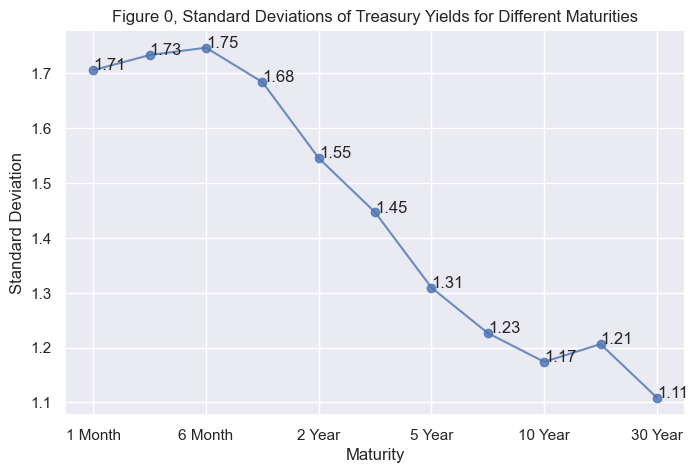

In [12]:
fig, ax = plt.subplots()
y_std.plot(figsize = (8,5),marker='o', title='Figure 0, Standard Deviations of Treasury Yields for Different Maturities', alpha=0.8) # Plot standard deviations of yields of different maturies
plt.xlabel("Maturity")
plt.ylabel("Standard Deviation")
for i in range(len(y_std)):
    ax.annotate(str(round(y_std.iloc[i],2)),xy=(i,y_std.iloc[i]))
plt.show()

波动率曲线图：
📉 短端波动剧烈：1月期波动率约1.7% → 对美联储政策最敏感
🛡️ 中端最稳定：3-7年期波动率约1.0% → "甜蜜点"
📈 长端回升：30年期波动率1.3% → 反映通胀预期变化<br>
<br>
## **3. Treasury Bond Price-Yield Curve**
以下是**债券价格-收益率曲线及多项式拟合的核心要点解析**，分两部分说明：

---

### **一、债券价格与收益率的关系（图1 & 图2核心）**
#### **1. 核心规律：反向变动**
- **收益率↑ → 债券价格↓**
  *例：国债收益率从2%升到3%，面值100元的债券价格可能跌至98元*
- **收益率↓ → 债券价格↑**
  *例：收益率从2%降到1%，同一债券价格可能涨至102元*

#### **2. 关键特征：凸性（Curvature）**
| **现象**                  | **图形表现**               | **实际影响**                  |
|---------------------------|----------------------------|-------------------------------|
| **非线性关系**            | 曲线向下弯曲（图1）        | 价格变动幅度 ≠ 收益率变动幅度 |
| **低利率时更敏感**        | 曲线左端更陡峭（图2）      | 收益率下降时价格暴涨          |
| **高利率时较迟钝**        | 曲线右端更平缓（图2）      | 收益率上升时价格缓跌          |
| **凸性效应**              | P2 > P1（等幅Δy下）        | 对投资者有利：涨多跌少        |

> 📌 **图2的D1/D2实验证明**：
> 当收益率同样下降Δy（D1=D2）：
> - **高收益区**（Y高位）→ 价格涨幅小（P1）
> - **低收益区**（Y低位）→ 价格涨幅大（P2）

#### **3. 风险管理意义**
- **利率风险不对称**：市场利率低位时，债券组合对加息更脆弱
- **凸性价值**：高凸性债券在波动市场中更具保护性（涨多跌少）

---

### **二、收益率曲线拟合（多项式拟合部分）**
#### **1. 目标：建模期限结构**
- **输入**：期限（1M, 1Y, 10Y...）→ **输出**：对应收益率
- **术语**：**Term Structure（期限结构）** = 收益率曲线的数学表达

#### **2. 为什么用多项式拟合？**
| 收益率曲线特征      | 多项式拟合解决方案         |
|----------------------|----------------------------|
| 非线性（短期陡峭）  | 高次项捕捉曲率            |
| 多拐点（驼峰/凹陷） | 分段多项式（如三次样条）  |
| 平滑过渡需求        | 强制导数连续的光滑约束    |


> 💡 **一句话总结**：
> 债券价格与收益率的**凸性关系**解释了利率风险的非对称性，而**多项式拟合技术**则是将这种复杂关系量化为可计算的数学模型的核心工具。

<br>
## **4. Polynomial Fitting for U.S. Treasury Yield Curve处理美国国债收益率曲线的多项式拟合**
We talked about U.S. Treasury yield curve in the previous lesson. Yield curve describes the relationship of bond yield and time to maturity (or maturity) of similar bonds. This relationship is also called the **term structure** of a yield curve. Analyzing term structure is critical in bond pricing and interest rate risk management. In this section, we will introduce methods to fit a yield curve. We will continue to use U.S. Treasury bond yields as an example. First, let's make a graph for the U.S. Treasury yield curve on 2020 January 10th.

Figure 3


/var/folders/rq/7sbky2g96jdgj8pp88lw9tnw0000gn/T/ipykernel_38858/2013921075.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.2f}%'.format(y) for y in ax.get_yticks()])


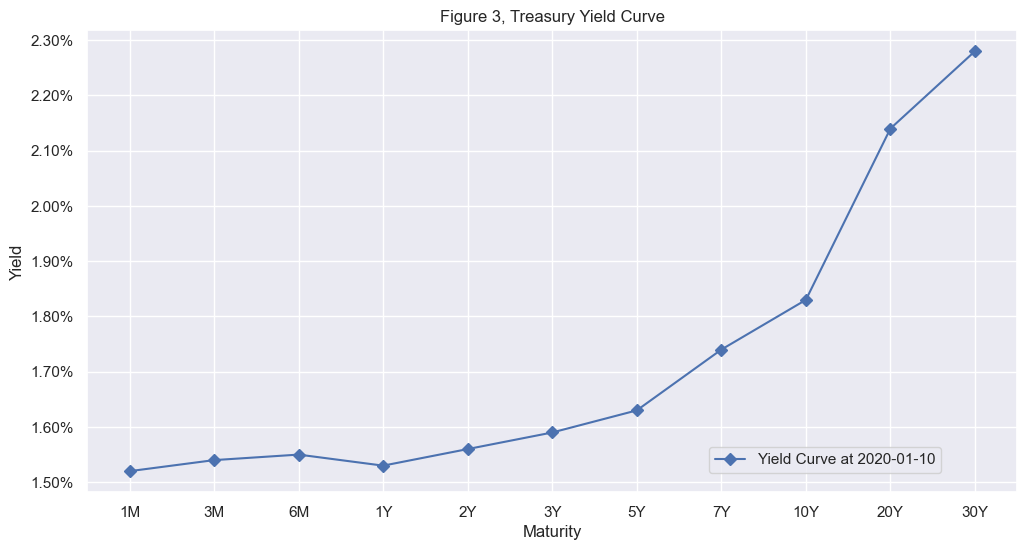

In [13]:
def plot_yield_curve(date, fig_n):
    maturities = ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y'] # Maturities
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(maturities, yields.loc[date], marker='D', label='Yield Curve at ' + date)

    ax.set_yticklabels(['{:.2f}%'.format(y) for y in ax.get_yticks()])
    ax.set_xticks(range(len(maturities)))
    ax.set_xticklabels(maturities)

    # Add labels and title
    ax.set_xlabel('Maturity')
    ax.set_ylabel('Yield')
    ax.set_title(fig_n+'Treasury Yield Curve')


    fig.legend(loc = [0.69, 0.14])

    # Show the plot
    plt.grid(True)
    plt.show()

print("Figure 3")
plot_yield_curve('2020-01-10','Figure 3, ')


以下是**该文本内容的核心要点解析**，分为两个主要部分：

---

### **第一部分：多项式拟合基础**
#### **1. 核心概念**
- **目标**：用数学函数描述**期限（t）→ 收益率（y）**的映射关系
- **本质**：$y = \beta_0 + \beta_1 t + \beta_2 t^2 + ... + \beta_n t^n$
  （用期限$t$的$n$次多项式预测收益率$y$）

#### **2. 关键特征**
| **要素**        | **说明**                          |
|-----------------|-----------------------------------|
| $\beta_0$~$\beta_n$ | 待估计参数（决定曲线形态）        |
| $n$ 的选择      | 阶数越高曲线越灵活（但可能过拟合）|
| **应用场景**    | 收益率曲线建模、利率预测          |

---

### **第二部分：Nelson Siegel模型详解**
#### **1. 模型定位**
- **专属领域**：国债收益率曲线建模的行业标准方法
- **核心优势**：
  ✅ 用**4个参数**描述复杂曲线
  ✅ 参数具经济意义（非黑箱）
  ✅ 被央行/机构广泛采用

#### **2. 模型公式**
$$y(t)=\beta_{0}+\beta_{1}\left( \frac{1-e^{-\lambda t}}{\lambda t} \right)+\beta_{2}\left( \frac{1-e^{-\lambda t}}{\lambda t}-e^{-\lambda t} \right)$$

#### **3. 参数经济学含义**
| **参数** | **名称**   | **控制特征**         | **现实对应**               |
|----------|------------|----------------------|----------------------------|
| $\beta_0$ | 水平因子   | 长期利率水平         | 30年期收益率               |
| $\beta_1$ | 斜率因子   | 短期vs长期利差       | 3月期-30年期利差           |
| $\beta_2$ | 曲率因子   | 中期驼峰/凹陷        | 5-10年期收益率凸起         |
| $\lambda$ | 衰减率     | 短期特征消失速度     | 曲线陡峭区域的收敛节奏     |

#### **4. 衰减率($\lambda$)的作用**
- **物理意义**：控制短期影响向长期过渡的速度
  ```mermaid
  graph LR
  λ小(λ=0.01) --> 缓变[曲线缓慢过渡]
  λ大(λ=0.5) --> 速变[曲线快速走平]
  ```
- **取值范围**：0~1（需通过网格搜索或经验确定）

#### **5. 模型价值**
- **解释现状**：分解曲线形态成因（如“牛市趋平”=$\beta_1↓+\beta_2↑$）
- **预测未来**：预判利率变动方向（例：$\beta_1$持续负值预示加息周期）
- **风险管理**：计算债券组合对三大因子的敏感度

---

### **Python实操预告**
- **工具包**：`nelson_siegel_svensson`（PyPI可安装）
- **关键步骤**：
  1. 转换期限为年单位（1月→0.083年）
  2. 组织收益率数组
  3. 调用`NelsonSiegelCurve.fit()`拟合参数
  4. 预测任意期限利率（如`model(2.5)`预测2.5年期收益）

> 💡 **一句话总结**：
> 该文本系统讲解了**用Nelson Siegel模型将收益率曲线数字化**的核心方法，
> 通过**四个具经济意义的参数**实现“解释历史→预测未来→管理风险”的全链条价值。

In [14]:
# Import the packages for fitting NS model
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
import numpy as np

After importing the necessary packages for fitting the NS model, we need to create variables for modeling. We first need to create a maturity variable $t$ in terms of year. For example, 1 month is 0.08333 year and 3-month is 0.25 year. The next variable is the yield variable. Both maturity variable and yield variable need to be in an array form. We are going to use the yields from 2020 January 10th (2020-01-10) as our example since we just drew the yield curve on that day in the last section.

In [19]:
# Create maturity and yield variables in array form
# 创建期限数组（单位：年）
t = np.array([
    1/12,      # 1个月 ≈ 0.0833年
    3/12,      # 3个月 = 0.25年
    6/12,      # 6个月 = 0.5年
    1,         # 1年
    2,         # 2年
    3,         # 3年
    5,         # 5年
    7,         # 7年
    10,        # 10年
    20,        # 20年
    30         # 30年
])

# 获取2020-01-10的收益率数据（转换为小数形式）
y = np.array(yields.loc["2020-01-10"])

# 拟合NS模型（tau0=1.0是λ衰减率的初始值）
curve, status = calibrate_ns_ols(t, y, tau0=1.0)

# 检查优化是否成功
if not status.success:
    raise RuntimeError("NS模型拟合失败！错误信息：" + status.message)

# 打印模型参数
print("="*50)
print("Nelson-Siegel 模型拟合结果：")
print(f"β₀ (水平因子): {curve.beta0:.4f} → 长期利率水平")
print(f"β₁ (斜率因子): {curve.beta1:.4f} → 短期/长期利差")
print(f"β₂ (曲率因子): {curve.beta2:.4f} → 中期驼峰程度")
print(f"τ (时间常数): {curve.tau:.4f} → 衰减速率(λ={1/curve.tau:.2f})")
print("="*50)


Nelson-Siegel 模型拟合结果：
β₀ (水平因子): 2.6377 → 长期利率水平
β₁ (斜率因子): -1.1026 → 短期/长期利差
β₂ (曲率因子): -1.1406 → 中期驼峰程度
τ (时间常数): 4.7500 → 衰减速率(λ=0.21)


Once the variables are ready, we can move to estimate the NS model.

The NS model result shows the estimated $\beta_{0}$, $\beta_{1}$, $\beta_{2}$, and decay rate. Now let's plot the graph to better understand the model result.

Text(0.5, 1.0, 'Figure 4, NS Model Result')

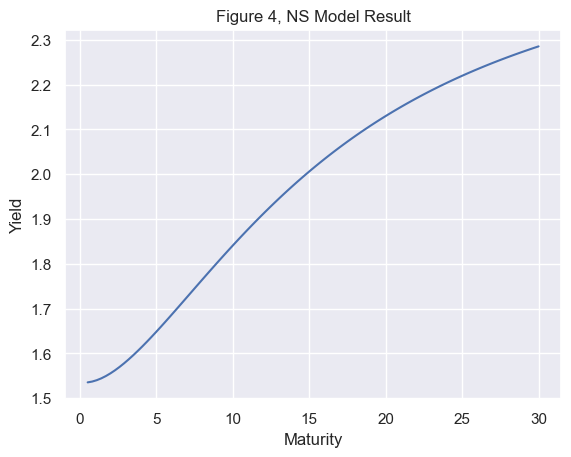

In [23]:
y_hat = curve
t_hat = np.linspace(0.5,30,100) ## 生成预测期限点（0.5-30年间的100个点）
plt.plot(t_hat, y_hat(t_hat)) ## 计算预测收益率
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.title("Figure 4, NS Model Result")

我们之前已经用2020-01-10的数据拟合了NS模型，并画出了拟合曲线。现在，我们要对另一个日期（2006-03-23）的数据进行同样的操作。

/var/folders/rq/7sbky2g96jdgj8pp88lw9tnw0000gn/T/ipykernel_38858/2013921075.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.2f}%'.format(y) for y in ax.get_yticks()])


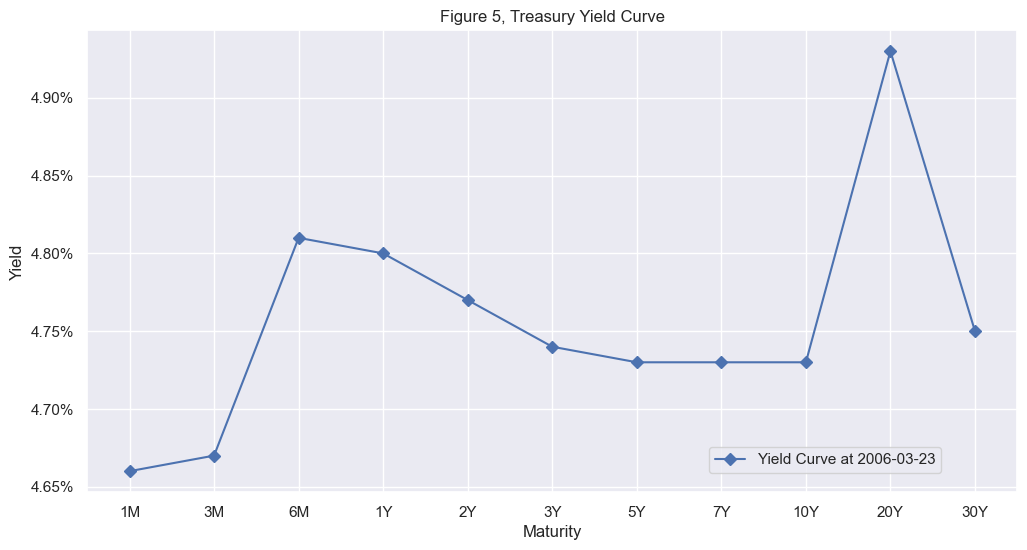

In [25]:
plot_yield_curve('2006-03-23','Figure 5, ')


In Figure 5, the yields from 6-month maturity to 10-year maturity demonstrate a downward slope shape, which is different from the yield curve at 2020-01-10. Let's see if the NS model will pick this up. We'll repeat the same process to model the yield curve on 2006-03-23.

In [29]:
y = np.array(yields.loc["2006-03-23"])
curve, status = calibrate_ns_ols(t, y, tau0=0.5)  # starting value of 0.5 for the optimization of tau
assert status.success# 打印模型参数
print("="*50)
print("Nelson-Siegel 模型拟合结果：")
print(f"β₀ (水平因子): {curve.beta0:.4f} → 长期利率水平")
print(f"β₁ (斜率因子): {curve.beta1:.4f} → 短期/长期利差")
print(f"β₂ (曲率因子): {curve.beta2:.4f} → 中期驼峰程度")
print(f"τ (时间常数): {curve.tau:.4f} → 衰减速率(λ={1/curve.tau:.2f})")
print("="*50)

Nelson-Siegel 模型拟合结果：
β₀ (水平因子): 4.7693 → 长期利率水平
β₁ (斜率因子): -0.1861 → 短期/长期利差
β₂ (曲率因子): 0.2594 → 中期驼峰程度
τ (时间常数): 0.2570 → 衰减速率(λ=3.89)


Text(0.5, 1.0, 'Figure 6, NS Model Result')

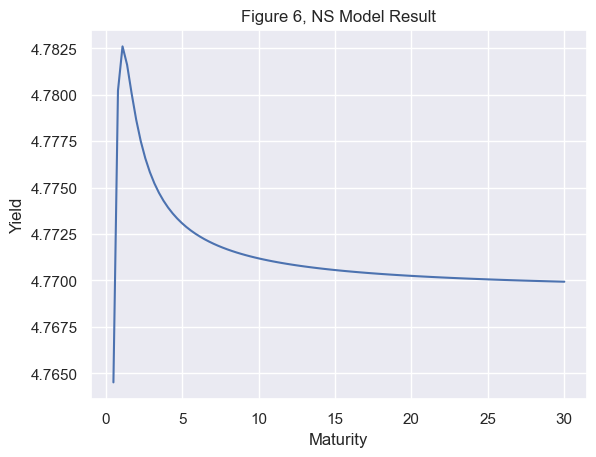

In [30]:
y_hat = curve
t_hat = np.linspace(0.5,30,100)
plt.plot(t_hat, y_hat(t_hat))
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.title("Figure 6, NS Model Result")

From the above Figure 6, we can see that the curve slopes downward after one year of maturity. This result is consistent with Figure 5, which we drew earlier.

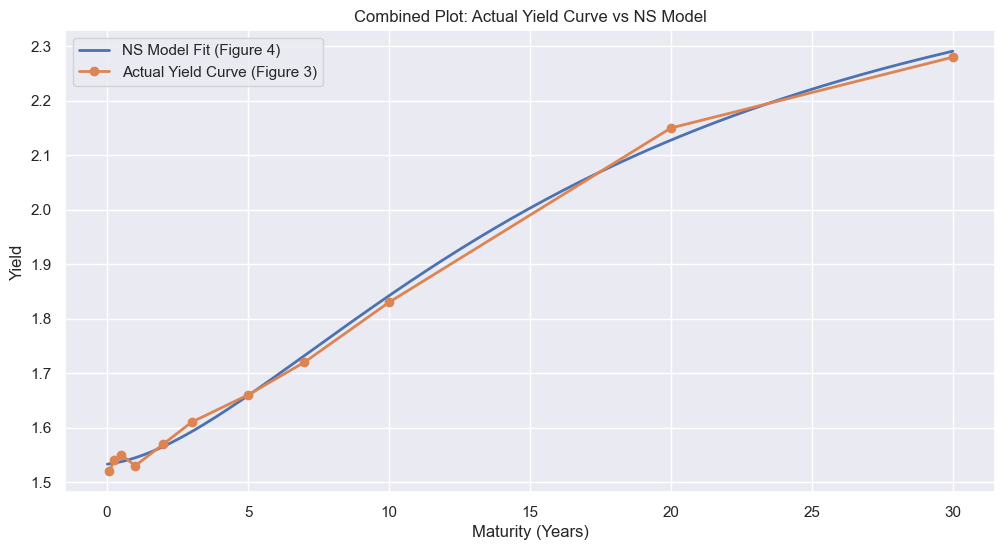

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 模拟真实收益率数据（图三）
maturities = ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
t_real = np.array([0.08333, 0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
y_real = np.array([1.52, 1.54, 1.55, 1.53, 1.57, 1.61, 1.66, 1.72, 1.83, 2.15, 2.28])  # 示例数据

# 模拟NS模型拟合曲线（图四）
from nelson_siegel_svensson.calibrate import calibrate_ns_ols

curve, status = calibrate_ns_ols(t_real, y_real, tau0=1.0)
y_ns_model = curve
t_hat = np.linspace(0.01, 30, 300)
y_hat = y_ns_model(t_hat)

# 画图
plt.figure(figsize=(12, 6))
plt.plot(t_hat, y_hat, label='NS Model Fit (Figure 4)', linewidth=2)
plt.plot(t_real, y_real, 'o-', label='Actual Yield Curve (Figure 3)', linewidth=2)
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield')
plt.title('Combined Plot: Actual Yield Curve vs NS Model')
plt.legend()
plt.grid(True)
plt.show()


## **5. Cubic Spline Fitting of Yield Curve  三次样条插值（Cubic Spline Fitting） 来拟合一条国债收益率曲线（Yield Curve**
In this section, we are going to introduce another popular method to fit a yield curve with data. It is called **cubic spline**. Spline fitting is a method under polynomial fitting. Please read the required reading "Spine Method of Interpolation" to study the theory of spline fitting, especially cubic spline fitting. We'll use the cubic spline fitting method in Python to fit a yield curve in the next section. Please be advised that in Lesson 4 "Application of Quadratic Spline Interpolation", there is a mistake in the note. In the big matrix presentation, the coefficient vector should be on the left-hand side of the equation, not the right-hand side.
<br>叫做 三次样条插值（Cubic Spline Fitting），这是一种用多段三次多项式来拼接曲线的方法。每一段在衔接处都保持光滑（即导数连续）。

<br>
### **5.1 Python Application: Use Cubic Spline Fitting to Fit a Yield Curve**
In this section, we'll demonstrate how to fit a yield curve cubic spline. For ease of demonstration, 接下来他们会用 Python 举个例子：
取出 2020 年 1 月 10 日 当天的美国国债收益率（只取 2 年、5 年、10 年 和 30 年）
然后用三次样条插值法，来拟合一整条光滑的收益率曲线。

In [32]:
yields.loc["2020-01-10"]

1 Month    1.52
3 Month    1.54
6 Month    1.55
1 Year     1.53
2 Year     1.56
3 Year     1.59
5 Year     1.63
7 Year     1.74
10 Year    1.83
20 Year    2.14
30 Year    2.28
Name: 2020-01-10 00:00:00, dtype: float64

🧮 拟合过程大致步骤
	1.	定点数据：
	•	t = [2, 5, 10, 30]（年限）
	•	y = [对应收益率]（格式化为百分比，如 1.56 等）

In [33]:
t = np.array([2,5,10,30])
y = np.array([1.56,1.63,1.83,2.28])

3.	设置条件：
	•	穿点条件：每个 segment 的两端要通过起止的 observed yields，共 6 条方程。
	•	一阶导连续：在 x=5、10 处一阶导相等，2 条方程。
	•	二阶导连续：在 x=5、10 处二阶导相等，2 条方程。
	•	端点自然边界：在 x=2 和 x=30 处二阶导 = 0，2 条式子。

一共形成 12 条线性方程，写作矩阵 A · c = y。<br>
<br>
$$f\left( x \right)=a_{1}x^{3}+b_{1}x^{2}+c_{1}x+d_{1}, \text{when }2\le x\le 5$$
$$f\left( x \right)=a_{2}x^{3}+b_{2}x^{2}+c_{2}x+d_{2}, \text{when }5\le x\le 10$$
$$f\left( x \right)=a_{3}x^{3}+b_{3}x^{2}+c_{3}x+d_{3}, \text{when }10\le x\le 30$$
<br>
<br>
From the above equations, we have 12 unknowns. Hence, we need 12 equations to solve for the 12 parameters. Let's write out the equations that each cubic spline function would go through at two consecutive data points.
<br>
<br>
$$a_{1}(2)^{3}+b_{1}(2)^{2}+c_{1}(2)+d_{1}=1.56\;\;\;(1)$$
$$a_{1}(5)^{3}+b_{1}(5)^{2}+c_{1}(5)+d_{1}=1.63\;\;\;(2)$$
<br>
<br>
$$a_{2}(5)^{3}+b_{2}(5)^{2}+c_{2}(5)+d_{2}=1.63\;\;\;(3)$$
$$a_{2}(10)^{3}+b_{2}(10)^{2}+c_{2}(10)+d_{2}=1.83\;\;\;(4)$$
<br>
<br>
$$a_{3}(10)^{3}+b_{3}(10)^{2}+c_{3}(10)+d_{3}=1.83\;\;\;(5)$$
$$a_{3}(30)^{3}+b_{3}(30)^{2}+c_{3}(30)+d_{3}=2.28\;\;\;(6)$$
<br>
<br>
Now, let's write down the equations that show the first derivatives of two consecutive cubic splines being continuous at the common interior points.
<br>
<br>
$$3a_{1}(5)^{2}+2b_{1}(5)+c_{1}=3a_{2}(5)^{2}+2b_{2}(5)+c_{2}\;\;\;(7)$$
$$3a_{2}(10)^{2}+2b_{2}(10)+c_{2}=3a_{3}(10)^{2}+2b_{3}(10)+c_{3}\;\;\;(8)$$
<br>
<br>
And then we'll write the equations that show the second derivatives of two consecutive cubic splines being continuous at the common interior points.
<br>
<br>
$$6a_{1}(5)+2b_{1}=6a_{2}(5)+2b_{2}\;\;\;(9)$$
$$6a_{2}(10)+2b_{2}=6a_{3}(10)+2b_{3}\;\;\;(10)$$
<br>
<br>
The last two equations are boundary conditions. We set the second derivatives of the cubic splines at the end points to be zeroes.
<br>
<br>
$$6a_{1}(2)+2b_{1}=0\;\;\;(11)$$
$$6a_{3}(30)+2b_{3}=0\;\;\;(12)$$
<br>
<br>
Now we have 12 equations to solve for 12 parameters. We can write the whole problem as a big matrix equation.
<br>
<br>
$$\begin{bmatrix}
8 & 4 & 2 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
125 & 25 & 5 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 125 & 25 & 5 & 1 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 1000 & 100 & 10 & 1 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1000 & 100 & 10 & 1 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 27000 & 900 & 30 & 1 \\
 75 & 10 & 1 & 0 & -75 & -10 & -1 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 300 & 20 & 1 & 0 & -300 & -20 & -1 & 0 \\
 30 & 2 & 0 & 0 & -30 & -2 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 60 & 2 & 0 & 0 & -60 & -2 & 0 & 0 \\
 12 & 2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 180 & 2 & 0 & 0
\end{bmatrix}\bullet\begin{bmatrix}
a_{1} \\
b_{1} \\
c_{1} \\
d_{1} \\
a_{2} \\
b_{2} \\
c_{2} \\
d_{2} \\
a_{3} \\
b_{3} \\
c_{3} \\
d_{3}
\end{bmatrix}=\begin{bmatrix}
1.56 \\
1.63 \\
1.63 \\
1.83 \\
1.83 \\
2.28 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0
\end{bmatrix}$$
<br>
<br>
We can write the above matrix equation as the following equation:
<br>
<br>
$$A\bullet c=y$$
<br>
<br>
$A$ is the squared matrix. $c$ is the coefficient vector and $y$ is the output vector. In order to solve for $c$, we will use the following linear algebra rule.
<br>
<br>
$$c=A^{-1}\bullet y$$
<br>
<br>
$A^{-1}$ is the inverse of the squared matrix. The following Python code is used to solve for the coefficient vector.


	4.	求解系数：
通过线性代数（如 numpy.linalg.inv(A) 或直接 np.linalg.solve），得到系数向量 c = [a1,b1,c1,d1, a2,b2,c2,d2, a3,b3,c3,d3]。
	5.	生成曲线：
选取多个 x 值（如 np.linspace(2,30,100)），分别用对应区间的 spline 函数 f₁, f₂, f₃ 计算 y，绘制出一条平滑连续的曲线，且我们保留原始 4 个点作为红点标记。

	5.	生成曲线：
选取多个 x 值（如 np.linspace(2,30,100)），分别用对应区间的 spline 函数 f₁, f₂, f₃ 计算 y，绘制出一条平滑连续的曲线，且我们保留原始 4 个点作为红点标记。

In [34]:
# Create output vector y (out variable) and squared matrix A (input variable)
out = np.array([1.56,1.63,1.63,1.83,1.83,2.28,0,0,0,0,0,0])
input = np.array([[8,4,2,1,0,0,0,0,0,0,0,0],[125,25,5,1,0,0,0,0,0,0,0,0],[0,0,0,0,125,25,5,1,0,0,0,0],[0,0,0,0,1000,100,10,1,0,0,0,0], \
                  [0,0,0,0,0,0,0,0,1000,100,10,1],[0,0,0,0,0,0,0,0,27000,900,30,1],[75,10,1,0,-75,-10,-1,0,0,0,0,0],[0,0,0,0,300,20,1,0,-300,-20,-1,0], \
                  [30,2,0,0,-30,-2,0,0,0,0,0,0],[0,0,0,0,60,2,0,0,-60,-2,0,0],[12,2,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,180,2,0,0]])

In [35]:
# Solve for coefficient vector and reshape to an 3 by 4 array (lines variable)
# Make sure to give enough decimals since all coefficients are relatively small. If there is not decimal points, the following coefficient results and graphs will be rough
lines = np.round(np.dot(np.linalg.inv(input), out).reshape(-1,4),decimals=8)
lines

array([[ 3.96060000e-04, -2.37634000e-03,  2.45215100e-02,
         1.51729391e+00],
       [-3.31400000e-04,  8.53548000e-03, -3.00376300e-02,
         1.60822581e+00],
       [ 2.34400000e-05, -2.10968000e-03,  7.64139800e-02,
         1.25338710e+00]])

From the above result, we can see the coefficients are presented as a 3 X 4 array.
<br>
<br>
$$\begin{bmatrix}
a_{1} & b_{1} & c_{1} & d_{1} \\
a_{2} & b_{2} & c_{2} & d_{2}  \\
a_{3} & b_{3} & c_{3} & d_{3}
\end{bmatrix}$$
<br>
<br>
Now we can draw a smooth curve from maturity 2 to maturity 30 using Python.

In [36]:
# Calculates x**0 + x**1 + x**2 + x**3
def plot_num(values, coeffs):
    # Coeffs are assumed to be in order 0, 1, ..., n-1
    expanded = np.hstack([coeffs[i] * (values ** i) for i in range(0, len(coeffs))])
    return np.sum(expanded, axis=1)


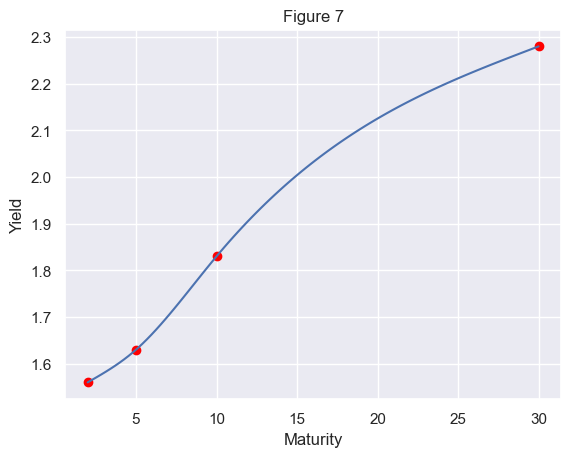

In [37]:
# Simulate the 100 paired data points and draw the graph
xs = np.linspace(2,30, 100)

y1s = plot_num(xs[xs<5].reshape(-1,1), lines[0][::-1])
y2s = plot_num(xs[(xs>=5) & (xs<10)].reshape(-1,1), lines[1][::-1])
y3s = plot_num(xs[xs>=10].reshape(-1,1), lines[2][::-1])
ys = np.concatenate([y1s, y2s, y3s])


plt.plot(xs, ys)
plt.scatter(t, y,c="red")
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.title("Figure 7")
plt.show()


这段内容展示了如何通过三段 Cubic Spline（立方样条） 拟合多个利率到期点（maturities & yields 数据），从而在没有完整观测的情况下，构建平滑的国债收益率曲线。下面我用大白话重述整个思路：

⸻

📊 为什么要做 Cubic Spline 拟合？

你只有几个到期点（例如 2、5、10、30 年国债），但你想要在任意其他年份（比如 7 年、12 年、15 年）知道对应收益率。直接连接点的话，曲线是折线不平滑，利率估算不理想。

所以 Cubic Spline 就派上用场了：
它在每一段之间用三次多项式拟合，保证：
	1.	每段曲线穿越两端已知点。
	2.	在各节点处一阶和二阶导数连续（确保弯腰和平滑过渡）。
	3.	两端边界条件（通常设二阶导数为 0），形成自然样条。

⸻

🧮 拟合过程大致步骤
	1.	定点数据：
	•	t = [2, 5, 10, 30]（年限）
	•	y = [对应收益率]（格式化为百分比，如 1.56 等）
	2.	拆段式三次多项式：
三段 spline：

f₁(x) = a₁x³ + b₁x² + c₁x + d₁   (2 ≤ x ≤ 5)
f₂(x) = a₂x³ + b₂x² + c₂x + d₂   (5 ≤ x ≤ 10)
f₃(x) = a₃x³ + b₃x² + c₃x + d₃   (10 ≤ x ≤ 30)

共 12 个未知系数。

	3.	设置条件：
	•	穿点条件：每个 segment 的两端要通过起止的 observed yields，共 6 条方程。
	•	一阶导连续：在 x=5、10 处一阶导相等，2 条方程。
	•	二阶导连续：在 x=5、10 处二阶导相等，2 条方程。
	•	端点自然边界：在 x=2 和 x=30 处二阶导 = 0，2 条式子。

一共形成 12 条线性方程，写作矩阵 A · c = y。
	4.	求解系数：
通过线性代数（如 numpy.linalg.inv(A) 或直接 np.linalg.solve），得到系数向量 c = [a1,b1,c1,d1, a2,b2,c2,d2, a3,b3,c3,d3]。
	5.	生成曲线：
选取多个 x 值（如 np.linspace(2,30,100)），分别用对应区间的 spline 函数 f₁, f₂, f₃ 计算 y，绘制出一条平滑连续的曲线，且我们保留原始 4 个点作为红点标记。

⸻

✅ Figure 7 看什么信息？
	•	光滑曲线：显示从 2 到 30 年之间利率随 maturity 的变化趋势。
	•	保证平滑性（曲线没折角）而不仅仅是线性插值。
	•	对定价、贴现未来现金流或计算久期非常有用。

⸻

🛠 后续操作
	1.	计算贴现因子：DF(t) = \exp(-y(t) * t)。
	2.	评估现金流现值：用 spline 拟合出的 y(t) 得到各现金流对应 DF。
	3.	资产估值：用求和方式得到总 PV，判断是否合理。

⸻

🧾 总结
	•	为什么用：弥补离散收益率点之间的信息缺口。
	•	怎样用：Spline 构建平滑曲线。
	•	最终用到哪里：资产估值／风险分析／交易决策等。

如果你还想把这个流程放在 codepad 里做格式化 copy-paste，或想加上图注、中文注释或更详细解释都可以告诉我，我可以帮你整理好！